In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/TES/dataproduksi perikanan seruyan.xlsx')

In [ ]:
df.head(10)

,No.,Tahun,Kecamatan,Produksi(Ton Basah)
0,0,2013,Seruyan Hilir,11838.35
1,1,2013,Seruyan Hilir Timur,4512.55
2,2,2013,Danau Sembuluh,1581.30
3,3,2013,Seruyan Raya,558.87
4,4,2013,Hanau,933.28
5,5,2013,Danau Seluluk,409.50
6,6,2013,Seruyan Tengah,322.60
7,7,2013,Batu Ampar,247.10
8,8,2013,Seruyan Hulu,203.00
9,9,2013,Suling Tambun,189.25


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   No.                  100 non-null    int64  
 1   Tahun                100 non-null    int64  
 2   Kecamatan            100 non-null    object 
 3   Produksi(Ton Basah)  100 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 3.3+ KB


In [ ]:
df.describe()

,No.,Tahun,Produksi(Ton Basah)
count,100.000000,100.000000,100.000000
mean,49.500000,2017.500000,2333.598900
std,29.011492,2.886751,4879.486765
min,0.000000,2013.000000,25.000000
25%,24.750000,2015.000000,139.757500
50%,49.500000,2017.500000,449.675000
75%,74.250000,2020.000000,1779.865000
max,99.000000,2022.000000,35522.490000


In [ ]:
# Bersihkan data
df = df.iloc[:, 1:]
df.columns = ["Tahun", "Kecamatan", "Produksi(Ton Basah)"]
df = df.iloc[1:].reset_index(drop=True)
df["Tahun"] = pd.to_numeric(df["Tahun"], errors='coerce')
df["Produksi(Ton Basah)"] = pd.to_numeric(df["Produksi(Ton Basah)"], errors='coerce')

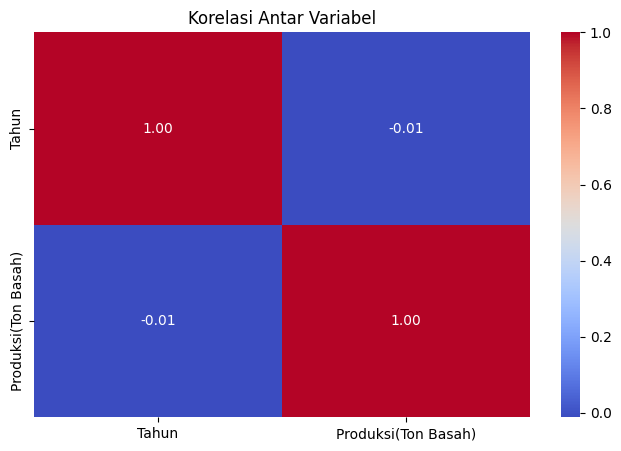

In [ ]:
!pip install seaborn
import seaborn as sns

df_numeric = df.select_dtypes(include=['number'])

# Pastikan tidak ada NaN sebelum visualisasi
df_numeric = df_numeric.dropna()

plt.figure(figsize=(8,5))
sns.heatmap(df_numeric.corr(), annot=True, cmap="coolwarm", fmt=".2f") # Now sns is defined and accessible
plt.title("Korelasi Antar Variabel")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # Import train_test_split



# Daftar kecamatan
kecamatan_list = df['Kecamatan'].unique()
future_years = np.arange(2023, 2028)

# Output: Prediksi & Evaluasi
all_predictions = []
model_evaluations = []

for kec in kecamatan_list:
    df_kec = df[df['Kecamatan'] == kec].copy()
    df_kec = df_kec.sort_values('Tahun')

    X = df_kec[['Tahun']].values
    y = df_kec['Produksi(Ton Basah)'].values

    # === SPLIT DATA ===
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
for kec in kecamatan_list:
    df_kec = df[df['Kecamatan'] == kec].copy()
    df_kec = df_kec.sort_values('Tahun')

    X = df_kec[['Tahun']].values
    y = df_kec['Produksi(Ton Basah)'].values

    # ========== LINEAR REGRESSION ==========
    lr = LinearRegression()
    lr.fit(X, y)
    y_pred_lr = lr.predict(X)

    # Evaluasi LR
    mae_lr = mean_absolute_error(y, y_pred_lr)
    rmse_lr = np.sqrt(mean_squared_error(y, y_pred_lr))
    r2_lr = r2_score(y, y_pred_lr)

    # ========== SVR ==========
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

    svr = SVR(kernel='rbf')
    svr.fit(X_scaled, y_scaled)
    y_pred_svr_scaled = svr.predict(X_scaled)
    y_pred_svr = scaler_y.inverse_transform(y_pred_svr_scaled.reshape(-1, 1)).ravel()

    # Evaluasi SVR
    mae_svr = mean_absolute_error(y, y_pred_svr)
    rmse_svr = np.sqrt(mean_squared_error(y, y_pred_svr))
    r2_svr = r2_score(y, y_pred_svr)

    # Simpan evaluasi model
    model_evaluations.append({
        'Kecamatan': kec,
        'MAE_LR': mae_lr,
        'RMSE_LR': rmse_lr,
        'R2_LR': r2_lr,
        'MAE_SVR': mae_svr,
        'RMSE_SVR': rmse_svr,
        'R2_SVR': r2_svr,
        'Model_Terbaik': 'LR' if rmse_lr < rmse_svr else 'SVR'
    })

    # ========== PREDIKSI TAHUN 2023–2027 ==========
    pred_lr = lr.predict(future_years.reshape(-1, 1))
    pred_svr_scaled = svr.predict(scaler_X.transform(future_years.reshape(-1, 1)))
    pred_svr = scaler_y.inverse_transform(pred_svr_scaled.reshape(-1, 1)).ravel()

    for yr, p_lr, p_svr in zip(future_years, pred_lr, pred_svr):
        all_predictions.append({
            'Kecamatan': kec,
            'Tahun': yr,
            'Prediksi_LR': p_lr,
            'Prediksi_SVR': p_svr
        })

# Buat DataFrame hasil evaluasi dan prediksi
df_eval = pd.DataFrame(model_evaluations)
df_pred = pd.DataFrame(all_predictions)

# Simpan sebagai file jika dibutuhkan
df_eval.to_excel("evaluasi_model_per_kecamatan.xlsx", index=False)
df_pred.to_excel("prediksi_produksi_2023_2028.xlsx", index=False)

# Tampilkan hasil evaluasi dan sebagian hasil prediksi
print("Evaluasi Model per Kecamatan:")
print(df_eval)

print("\nContoh Hasil Prediksi:")
print(df_pred.head(20))

Evaluasi Model per Kecamatan:
             Kecamatan       MAE_LR      RMSE_LR     R2_LR      MAE_SVR  \
0  Seruyan Hilir Timur  1872.411455  2393.798383  0.281176  1376.237328   
1       Danau Sembuluh   600.308400   670.880757  0.225025   286.943083   
2         Seruyan Raya   223.771273   258.226415  0.401759   123.116048   
3                Hanau   332.373418   391.467425  0.084265   191.402476   
4        Danau Seluluk   143.951745   177.658965  0.224794    80.642492   
5       Seruyan Tengah   124.159406   149.556784  0.086041    89.236313   
6           Batu Ampar   110.001927   132.204446  0.021153    57.282087   
7         Seruyan Hulu    37.242945    46.466374  0.251975    21.464756   
8        Suling Tambun    44.690933    51.432942  0.065257    26.943495   
9        Seruyan Hilir  5242.579778  7739.843281  0.067363  3763.660752   

      RMSE_SVR    R2_SVR Model_Terbaik  
0  2211.285037  0.386609           SVR  
1   391.578977  0.735981           SVR  
2   194.650479  0.660

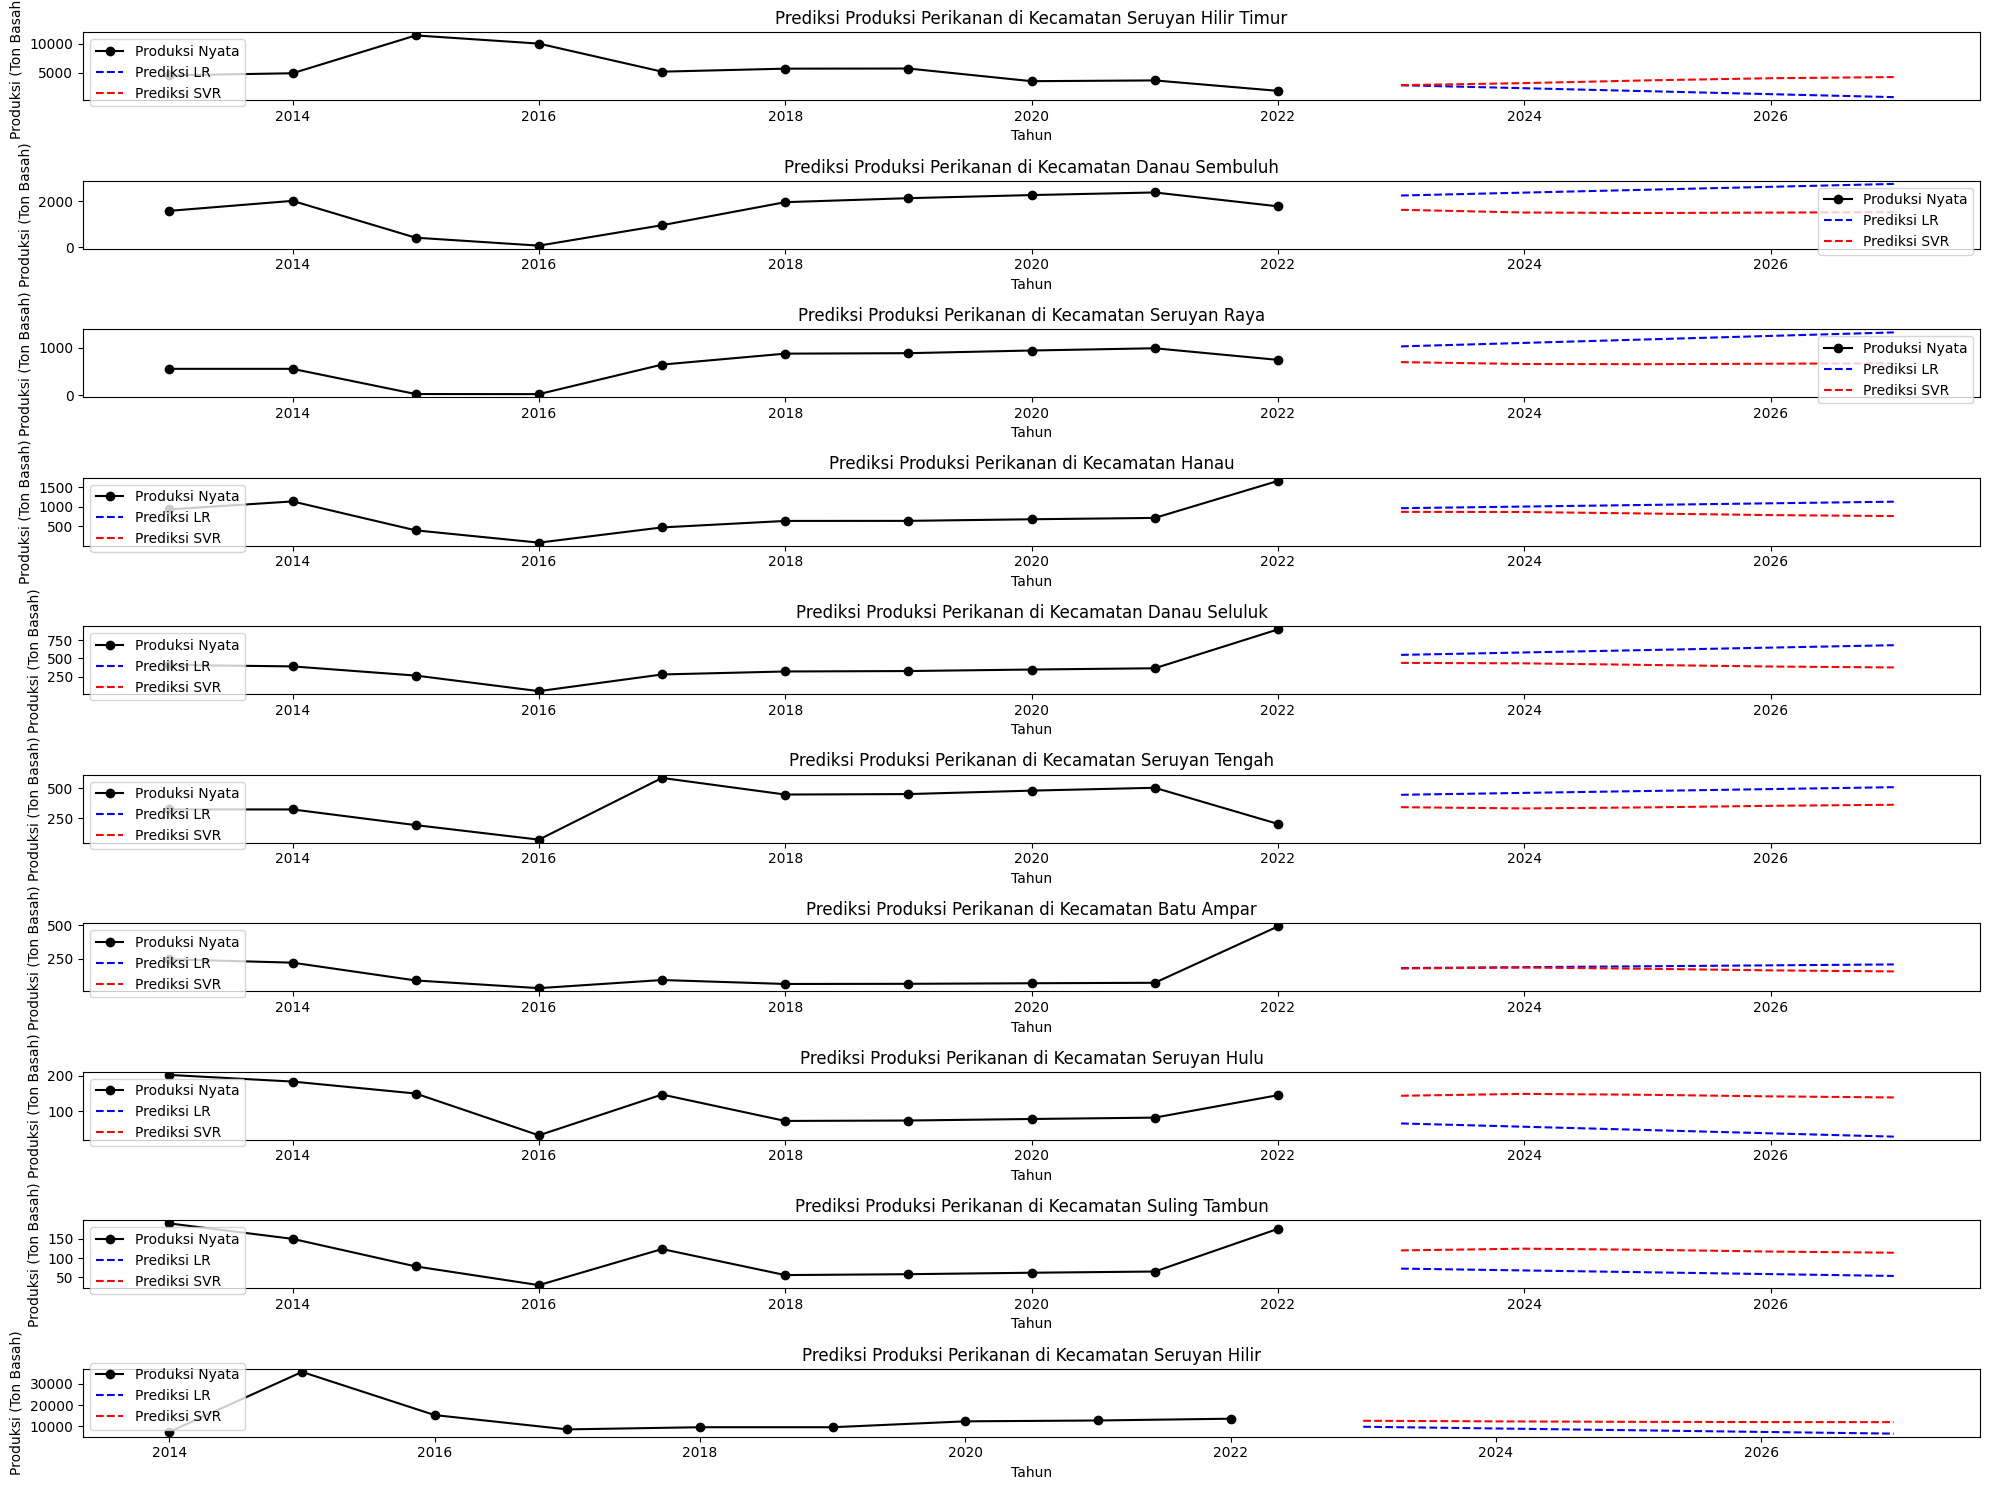

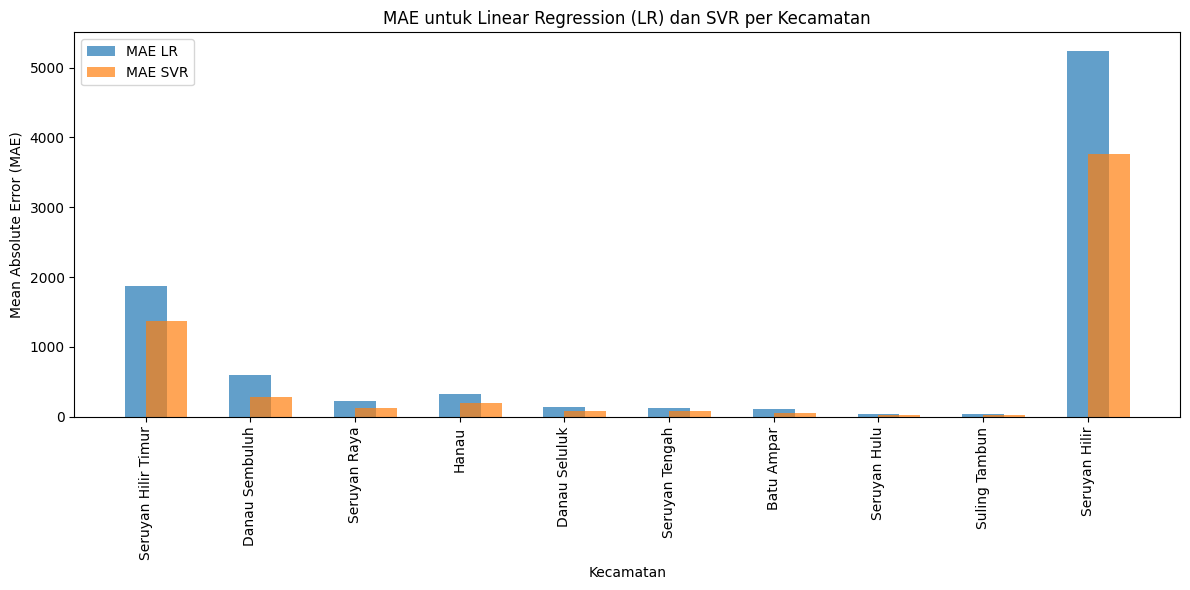

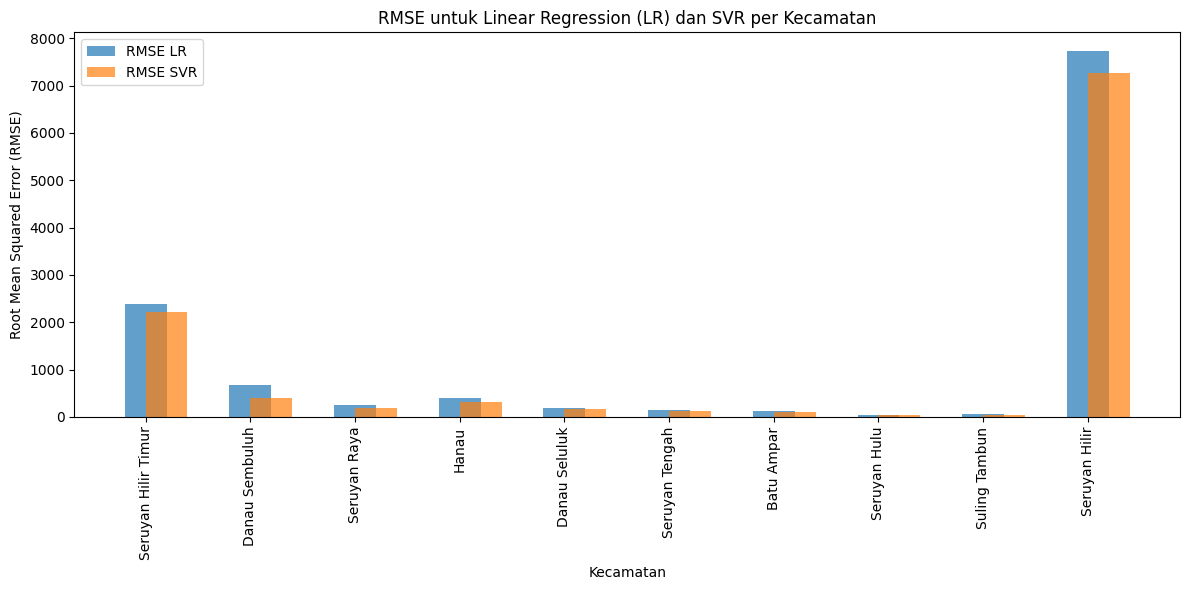

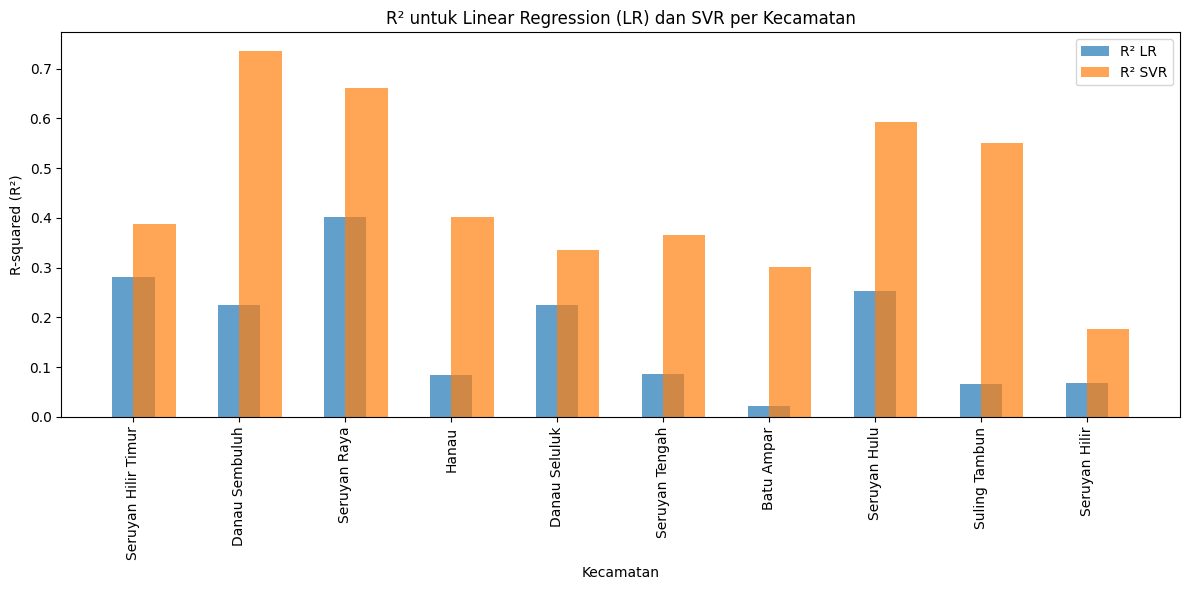

In [ ]:
# Visualisasi Prediksi vs Real Produksi
plt.figure(figsize=(20, 15))

for kec in kecamatan_list:
    # Filter prediksi untuk setiap kecamatan
    df_kec_pred = df_pred[df_pred['Kecamatan'] == kec]
    df_kec_actual = df[df['Kecamatan'] == kec].copy()
    df_kec_actual = df_kec_actual.sort_values('Tahun')

    # Plot Prediksi vs Real untuk LR dan SVR
    plt.subplot(len(kecamatan_list), 1, list(kecamatan_list).index(kec) + 1)
    plt.plot(df_kec_actual['Tahun'], df_kec_actual['Produksi(Ton Basah)'], label='Produksi Nyata', color='black', marker='o')
    plt.plot(df_kec_pred['Tahun'], df_kec_pred['Prediksi_LR'], label='Prediksi LR', color='blue', linestyle='--')
    plt.plot(df_kec_pred['Tahun'], df_kec_pred['Prediksi_SVR'], label='Prediksi SVR', color='red', linestyle='--')
    plt.title(f'Prediksi Produksi Perikanan di Kecamatan {kec}')
    plt.xlabel('Tahun')
    plt.ylabel('Produksi (Ton Basah)')
    plt.legend()

plt.tight_layout()
plt.show()

# Visualisasi Metrik Evaluasi Model (MAE, RMSE, R²)
evaluation_metrics = df_eval[['Kecamatan', 'MAE_LR', 'RMSE_LR', 'R2_LR', 'MAE_SVR', 'RMSE_SVR', 'R2_SVR']]

# Plot MAE untuk LR dan SVR
plt.figure(figsize=(12, 6))
plt.bar(evaluation_metrics['Kecamatan'], evaluation_metrics['MAE_LR'], label='MAE LR', alpha=0.7, width=0.4, align='center')
plt.bar(evaluation_metrics['Kecamatan'], evaluation_metrics['MAE_SVR'], label='MAE SVR', alpha=0.7, width=0.4, align='edge')
plt.xlabel('Kecamatan')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xticks(rotation=90)
plt.title('MAE untuk Linear Regression (LR) dan SVR per Kecamatan')
plt.legend()
plt.tight_layout()
plt.show()

# Plot RMSE untuk LR dan SVR
plt.figure(figsize=(12, 6))
plt.bar(evaluation_metrics['Kecamatan'], evaluation_metrics['RMSE_LR'], label='RMSE LR', alpha=0.7, width=0.4, align='center')
plt.bar(evaluation_metrics['Kecamatan'], evaluation_metrics['RMSE_SVR'], label='RMSE SVR', alpha=0.7, width=0.4, align='edge')
plt.xlabel('Kecamatan')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.xticks(rotation=90)
plt.title('RMSE untuk Linear Regression (LR) dan SVR per Kecamatan')
plt.legend()
plt.tight_layout()
plt.show()

# Plot R² untuk LR dan SVR
plt.figure(figsize=(12, 6))
plt.bar(evaluation_metrics['Kecamatan'], evaluation_metrics['R2_LR'], label='R² LR', alpha=0.7, width=0.4, align='center')
plt.bar(evaluation_metrics['Kecamatan'], evaluation_metrics['R2_SVR'], label='R² SVR', alpha=0.7, width=0.4, align='edge')
plt.xlabel('Kecamatan')
plt.ylabel('R-squared (R²)')
plt.xticks(rotation=90)
plt.title('R² untuk Linear Regression (LR) dan SVR per Kecamatan')
plt.legend()
plt.tight_layout()
plt.show()


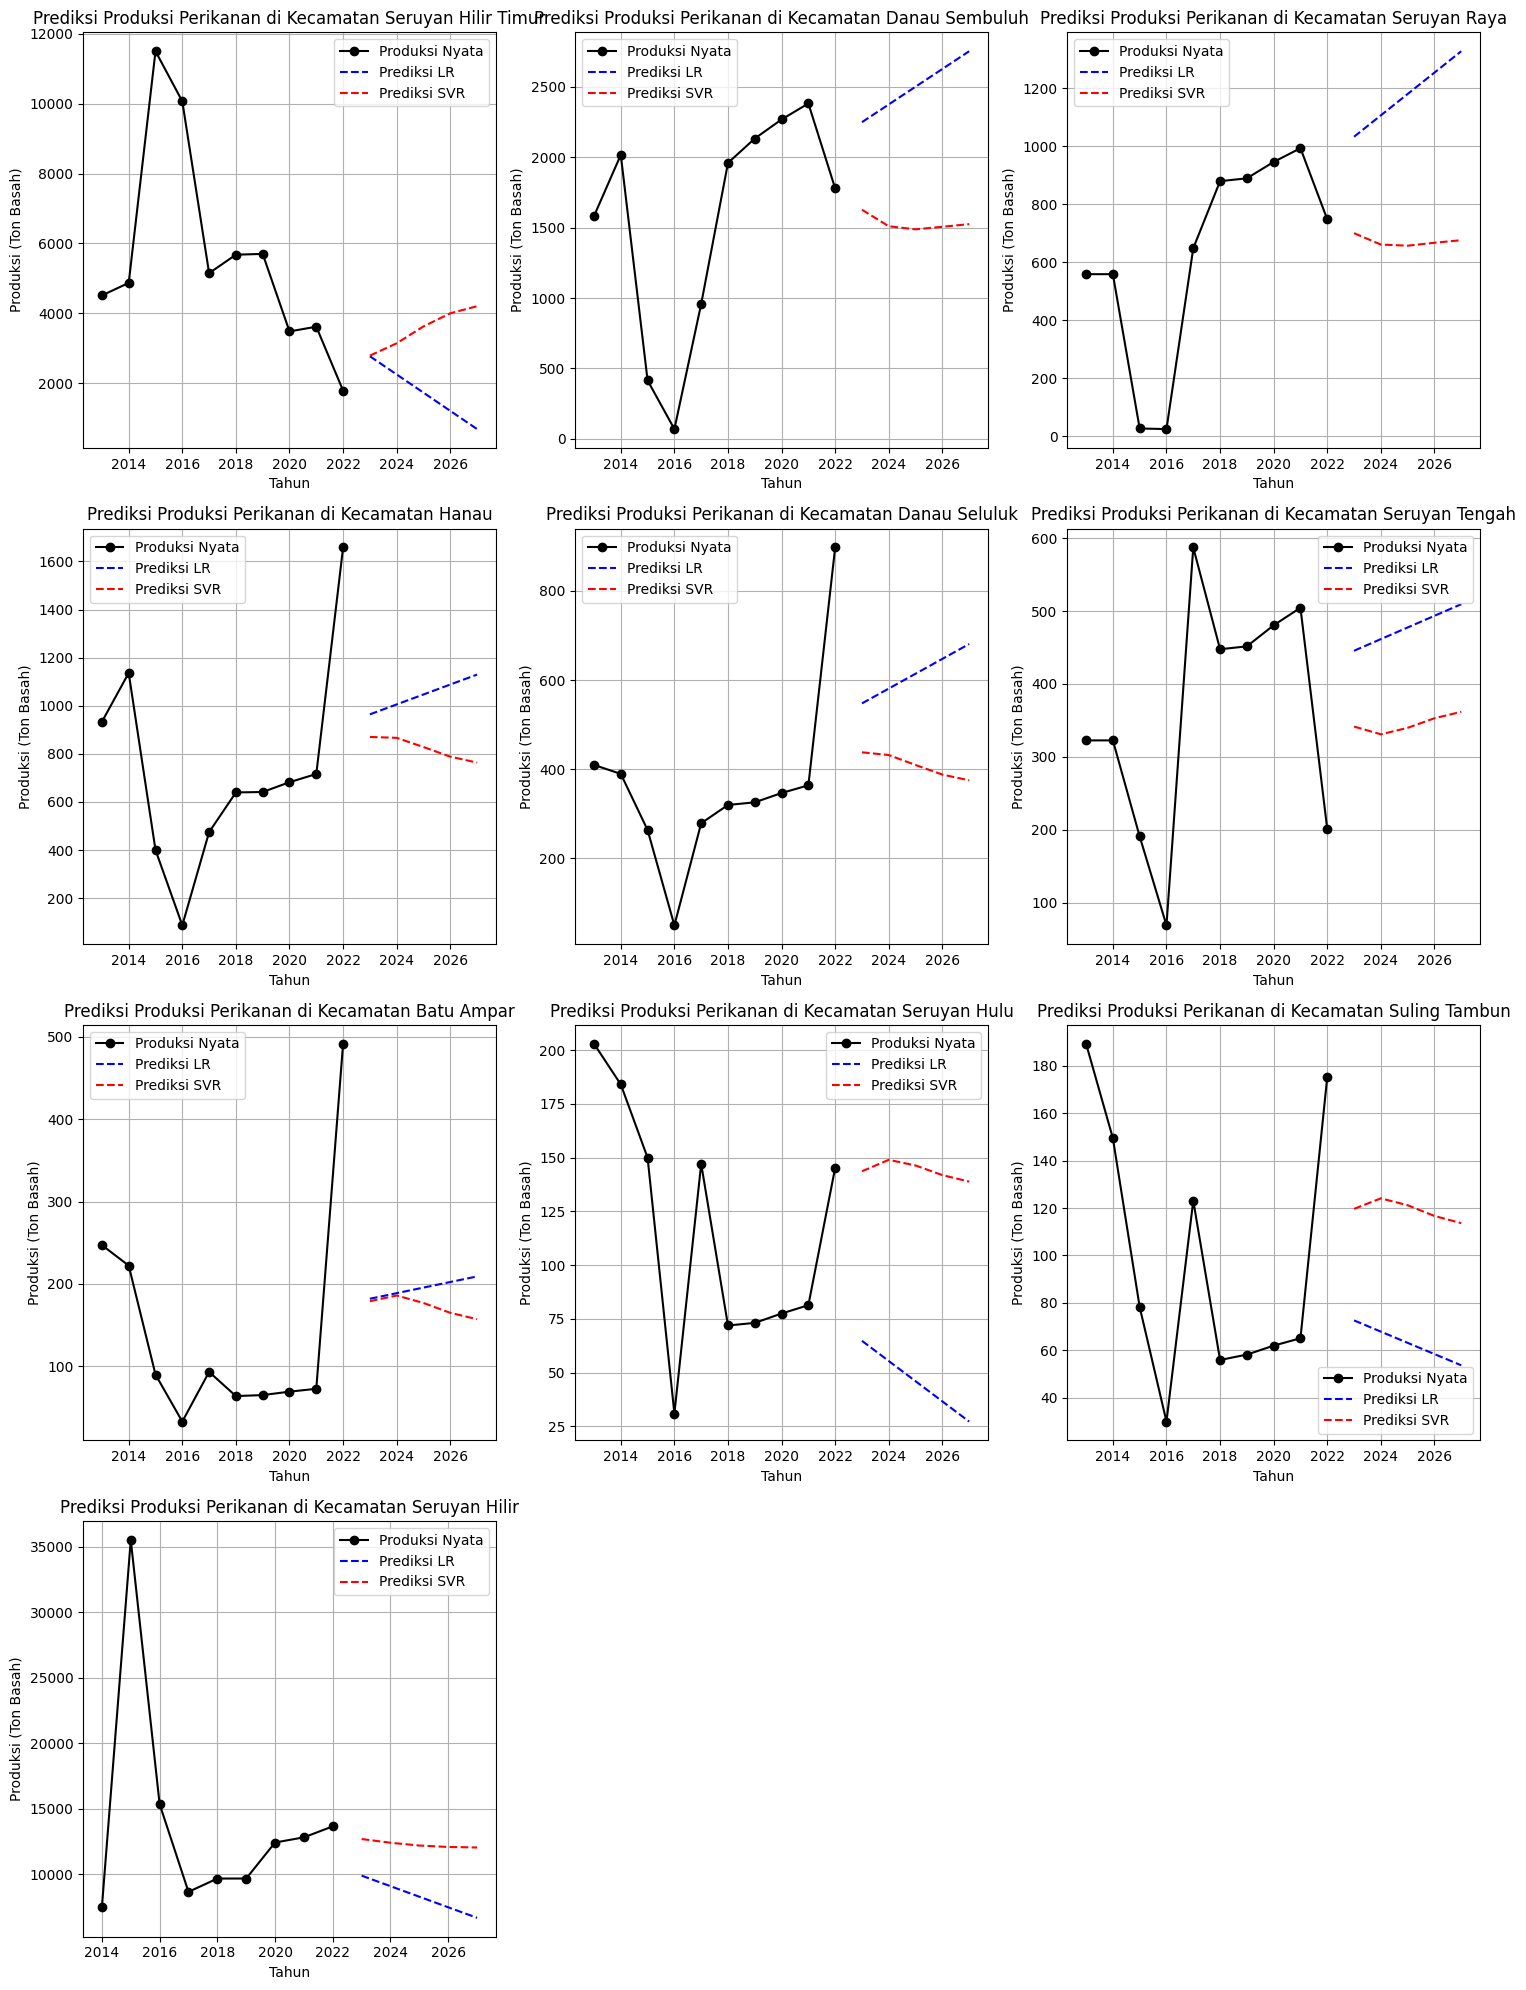

In [ ]:
# Visualisasi Prediksi vs Real Produksi
# Determine the number of rows and columns for the subplot grid
# Ensure kecamatan_list is defined
if 'kecamatan_list' not in locals() and 'kecamatan_list' not in globals():
    # Assuming df is available from previous cells
    if 'df' in globals():
        kecamatan_list = df['Kecamatan'].unique()
    else:
        print("Error: 'df' DataFrame not found. Cannot determine 'kecamatan_list'.")
        # Handle this error appropriately - perhaps skip visualization or load df again

if 'kecamatan_list' in locals() or 'kecamatan_list' in globals():
    n_kecamatans = len(kecamatan_list)
    n_cols = 3  # You can adjust this number based on how many columns you want
    n_rows = (n_kecamatans + n_cols - 1) // n_cols # Calculate the number of rows needed

    # Create a figure and a grid of subplots
    # Adjust figsize as needed for better visualization
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5)) # Adjust figsize as needed

    # Flatten the axes array for easier iteration if it's a 2D array
    if n_rows > 1 or n_cols > 1:
        axs = axs.flatten()
    else:
        # If it's a single plot (1 row, 1 column), axs is not an array
        axs = [axs]

    for i, kec in enumerate(kecamatan_list):
        # Select the current axis
        ax = axs[i]

        # Filter prediksi untuk setiap kecamatan
        df_kec_pred = df_pred[df_pred['Kecamatan'] == kec]
        df_kec_actual = df[df['Kecamatan'] == kec].copy()
        df_kec_actual = df_kec_actual.sort_values('Tahun')

        # Plot Prediksi vs Real untuk LR dan SVR on the current axis
        ax.plot(df_kec_actual['Tahun'], df_kec_actual['Produksi(Ton Basah)'], label='Produksi Nyata', color='black', marker='o')
        ax.plot(df_kec_pred['Tahun'], df_kec_pred['Prediksi_LR'], label='Prediksi LR', color='blue', linestyle='--')
        ax.plot(df_kec_pred['Tahun'], df_kec_pred['Prediksi_SVR'], label='Prediksi SVR', color='red', linestyle='--')

        ax.set_title(f'Prediksi Produksi Perikanan di Kecamatan {kec}')
        ax.set_xlabel('Tahun')
        ax.set_ylabel('Produksi (Ton Basah)')
        ax.legend()
        ax.grid(True) # Add grid for better readability

    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    # Adjust layout to prevent titles/labels from overlapping
    plt.tight_layout()

    # Show the figure with all subplots
    plt.show()
else:
    print("Skipping visualization as 'kecamatan_list' could not be determined.")

In [ ]:
import shutil
shutil.move("prediksi_produksi_2023_2028.xlsx", "/content/prediksi_produksi_2023_2028.xlsx")

'/content/prediksi_produksi_2023_2028.xlsx'

In [ ]:
from google.colab import files
files.download("prediksi_produksi_2023_2028.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>